(Forecasting Hurricane Trajectories with State Space Models)=
# Forecasting Hurricane Trajectories with State Space Models

:::{post} June 15, 2025 
:tags: state space model
:category: intermediate, tutorial
:author: Jonathan Dekermanjian
:::

## Introduction
In this case study we are going to forecast the paths of hurricanes by applying several State Space Models (SSM). We will begin with a simple two-dimensional constant acceleration tracking model, where we only have one parameter to estimate. Subsequently, we will progressively add complexity and parameters as we develop up our model. 

As a brief introduction to SSMs, the general idea is that we define our system using two equations.<br> 
The state equation and the observation equation. 

$$
x_{t+1} = A_{t}x_{t} + c_{t} + R_{t}\epsilon_{t}
$$ 

$$
y_{t} = Z_{t}x_{t} + d_{t} + \eta_{t}
$$

The process/state covariance is given by $\epsilon_{t} \sim N(0, Q_{t})$ where $Q_{t}$ is the process/state innovations and the observation/measurement covariance is given by $\eta_{t} \sim N(0, H_{t})$ where $H_{t}$ describes the uncertainty in the measurement device or measurement procedure. 

We have the following matrices:
|State Equation variables|Definition|
| --- | --- |
| $A_{t}$ | The state transition matrix at time $t$ defines the kinematics of the process generating the series.
| $x_{t}$ | The state vector at time $t$ describes the current state of the system.
| $c_{t}$ | Intercept vector at time $t$ can include covariates/control/exogenous variables that are deterministically measured.
| $R_{t}$ | Selection matrix at time $t$ selects which process innovations are allowed to affect the next state.
| $\epsilon_{t}$ | State/Process innovations at time $t$ defines the shocks influencing the changes in the state matrix.

<br>

|Observation Equation variables|Definition|
| --- | --- |
| $Z_{t}$ | The design matrix at time $t$ defines which states directly influence the observed variables.
| $x_{t}$ | The state vector at time $t$ describes the current state of the system.
| $d_{t}$ | Intercept vector at time $t$ can include covariates/control/exogenous variables that are deterministically measured.
| $\eta_{t}$ | observation/measurement error at time $t$ defines the uncertainty in the observation.

Estimation occurs in an iterative fashion (after an initialization step). In which the following steps are repeated:
1. Predict the next state vector $x_{t+1|t}$ and the next state/process covariance matrix $P_{t+1|t}$
2. Compute the Kalman gain
3. Estimate the current state vector and the current state/process covariance matrix

Where $P_{t}$ is the uncertainty in the state predictions at time $t$.

The general idea is that we make predictions based on our current state vector and state/process covariance (uncertainty) then we correct these predictions once we have our observations.

The following equations define the process:
|Description|Equation|
| --- | --- |
|Predict the next state vector| $\hat{x}_{t+1\|t} = A_{t}\hat{x}_{t\|t}$ |
|Predict the next state/process covariance| $P_{t+1\|t} = A_{t}P_{t+1\|t}A_{t}^{T} + Q$ |
|Compute Kalman Gain | $K_{t} = P_{t\|t-1}Z^{T}(ZP_{t\|t-1}Z^{T} + H_{t})^{-1}$ |
|Estimate current state vector| $\hat{x}_{t\|t} = \hat{x}_{t\|t-1} + K_{t}(y_{t} - Z\hat{x}_{t\|t-1})$ |
|Estimate current state/process covariance| $P_{t\|t} = (I - K_{t}Z_{t})P_{t\|t-1}(I - K_{t}Z_{t})^{T} + K_{t}H_{t}K_{t}^{T}$ |

:::{note}
We wrote the equation for $P_{t\|t}$ above using Joseph form, which is more numerically stable but also wordier. In different texts you may encounter this equation written in "standard" form.
:::

## Imports

In [1]:
# Import libraries
import re
import warnings

warnings.filterwarnings("ignore", message="The RandomType SharedVariables", category=UserWarning)

import arviz as az
import arviz.labels as azl
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import xarray as xr

:::{include} ../extra_installs.md
:::

In [2]:
# Required Extra Dependencies
import plotly.graph_objects as go
import plotly.io as pio
import polars as pl

from patsy import dmatrix
from pymc_extras.statespace.core.statespace import PyMCStateSpace
from pymc_extras.statespace.models.utilities import make_default_coords
from pymc_extras.statespace.utils.constants import (
    ALL_STATE_AUX_DIM,
    ALL_STATE_DIM,
    TIME_DIM,
)

pio.renderers.default = "iframe"

## Helper Functions

In [3]:
def ellipse_covariance(covariance: np.ndarray) -> np.ndarray:
    """
    Generates a 95% CI ellipse via a chi-square multivariate normal approximation.

    Parameters
    ----------
    covariance : ndarray
        The estimated covariance matrix

    Returns
    -------
    ndarray
        matrix of ellipse points
    """
    evals, evects = np.linalg.eig(covariance)
    largest_evect = evects[np.argmax(evals)]
    largest_eval = np.max(evals)
    smallest_eval = np.min(evals)
    angle = np.arctan2(largest_evect[1], largest_evect[0])
    if angle < 0:
        angle = angle + 2 * np.pi
    chisquare_val = 2.4477  # 95% CI MVN
    theta_grid = np.linspace(0, 2 * np.pi)
    phi = angle
    a = chisquare_val * np.sqrt(largest_eval)  # half-major axis scaled by k corresponding to 95% CI
    b = chisquare_val * np.sqrt(smallest_eval)  # half-minor axis scaled by k
    ellipse_x_r = a * np.cos(theta_grid)
    ellipse_y_r = b * np.sin(theta_grid)
    R = np.array([[np.cos(phi), np.sin(phi)], [-np.sin(phi), np.cos(phi)]])
    return np.array([ellipse_x_r, ellipse_y_r]).T @ R

In [4]:
def plot_hurricane_path(
    data: pl.DataFrame,
    posterior_mean: np.ndarray,
    predicted_covariance: np.ndarray,
    uncertainty_index: int = 3,
) -> go.Figure:
    """
    Plots actual vs predicted Hurricane path.

    Parameters
    ----------
    data : DataFrame
        dataframe containing the actual values
    posterior_mean : ndarray
        The posterior mean of the estimated distributions
    predicted_covariance : ndarray
        The predicted covariance matrices at each time point
    uncertainty_index : int
        When to start drawing the uncertainty on the map (due to huge uncertainty in the begining of the process)

    Returns
    -------
    Figure
        Plotly Hurricane Figure
    """
    fig = go.Figure()
    for i in range(predicted_covariance.shape[0]):
        if uncertainty_index and (
            i < uncertainty_index
        ):  # The uncertainty can be quite large depending on how you initialze P0
            continue
        r_ellipse = ellipse_covariance(predicted_covariance[i, :2, :2])
        means = posterior_mean[i]
        fig.add_trace(
            go.Scattermap(
                lon=r_ellipse[:, 0].astype(float) + means[0].values,
                lat=r_ellipse[:, 1].astype(float) + means[1].values,
                mode="lines",
                fill="toself",
                showlegend=True if i == uncertainty_index else False,
                legendgroup="HDI",
                hoverinfo="skip",
                marker_color="blue",
                name="95% CI",
            )
        )
    fig.add_traces(
        [
            go.Scattermap(
                lon=posterior_mean[:, 0],
                lat=posterior_mean[:, 1],
                name="predictions",
                mode="lines+markers",
                line=dict(color="lightblue"),
                hovertemplate=[
                    f"""<b>Period:</b> {i+1}<br><b>Longitude:</b> {posterior[0]:.1f}<br><b>Latitude:</b> {posterior[1]:.1f}<extra></extra>
                """
                    for i, posterior in enumerate(posterior_mean)
                ],
            ),
            go.Scattermap(
                lon=data["longitude"],
                lat=data["latitude"],
                name="actuals",
                mode="lines+markers",
                line=dict(color="black"),
                hovertemplate=[
                    f"""<b>Period:</b> {row['discrete_time']}<br><b>Longitude:</b> {row['longitude']:.1f}<br><b>Latitude:</b> {row['latitude']:.1f}<extra></extra>
                """
                    for row in data.iter_rows(named=True)
                ],
            ),
        ]
    )

    fig.update_layout(
        margin=dict(b=0, t=0, l=0, r=0),
        map={
            "bearing": 0,
            "center": go.layout.map.Center(
                lat=data["latitude"].mean() + 15.0, lon=data["longitude"].mean()
            ),
            "pitch": 0,
            "zoom": 2.0,
        },
    )
    return fig

In [5]:
def generate_period_forecasts(
    ssm_model: PyMCStateSpace,
    inference_data: az.InferenceData,
    data: pl.DataFrame,
    exogenous_data_name: str | None = None,
    padded_exogenous_data: pl.DataFrame | np.ndarray | None = None,
    periods: int = 4,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Produces an n-period ahead forecast.

    Parameters
    ----------
    ssm_model : PyMCStateSpace
        The statespace model you want to forecast with
    inference_data : InferenceData
        The fitted model trace
    data : DataFrame
        The actual data used for fitting
    exogenous_data_name : str | None
        The key/name you used to define your exogenous data
    padded_exogenous_data : DataFrame | ndarray | None
        The exogenous data padded for the number of forecasts you expect to make
    periods : int
        The number of periods to forecast

    Returns
    -------
    f_mean : ndarray
        posterior predictive mean of the forecasts
    cppc_vcov : ndarray
        posterior predictive variance-covariance matrix

    """
    n_t = inference_data.constant_data.time.shape[0]
    time_steps = np.arange(0, n_t, periods)
    period_forecasts = []

    for start in time_steps:
        scenario = None
        if padded_exogenous_data is not None:
            if isinstance(padded_exogenous_data, pl.DataFrame):
                exog_slice = padded_exogenous_data.slice(start, periods).to_numpy()
            else:
                exog_slice = padded_exogenous_data[start : start + periods]
            scenario = {exogenous_data_name: exog_slice}
        f = ssm_model.forecast(
            inference_data,
            start=start,
            periods=periods,
            filter_output="smoothed",
            progressbar=False,
            scenario=scenario,
        )
        period_forecasts.append(f)

    # Combine forecasts
    forecasts = xr.combine_by_coords(period_forecasts, combine_attrs="drop_conflicts")

    # Only look at in-sample forecasts
    forecasts = forecasts.sel(time=range(1, len(data)))

    f_mean = forecasts["forecast_observed"].mean(("chain", "draw"))
    longitude_cppc = az.extract(forecasts["forecast_observed"].sel(observed_state="x"))
    latitude_cppc = az.extract(forecasts["forecast_observed"].sel(observed_state="y"))
    cppc_var = forecasts["forecast_observed"].var(("chain", "draw"))
    cppc_covs = xr.cov(
        latitude_cppc["forecast_observed"], longitude_cppc["forecast_observed"], dim="sample"
    )
    covs_list = []
    for i in range(cppc_covs.shape[0]):
        covs_list.append(
            np.array(
                [
                    [
                        [cppc_var[i].values[0], cppc_covs[i].values.item()],
                        [cppc_covs[i].values.item(), cppc_var[i].values[1]],
                    ]
                ]
            )
        )
    cppc_vcov = np.concatenate(covs_list, axis=0)
    return f_mean, cppc_vcov

In [6]:
def evaluate_haversine(
    actuals: np.ndarray, predictions: np.ndarray
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Calculate the distance between two cartesian points using the Haversine formula.

    Parameters
    -----------
    actuals : ndarray
        Longitude and Latitude points of the actual hurricane path
    predictions : ndarray
        Longitude and Latitude points of the predicted hurricane path

    Returns
    --------
    errors : ndarray
        Distance between actual and predicted points in miles
    cumulative_errors : ndarray
        Cumulative mean of the errors
    mean_error : ndarray
        Mean of the errors
    """
    R = 3958.8  # Radius of our planet in miles

    actuals_radians = np.radians(actuals)
    predictions_radians = np.radians(predictions)

    differences = actuals_radians - predictions_radians

    a = (
        np.sin(differences[:, 1] / 2) ** 2
        + np.cos(actuals_radians[:, 1])
        * np.cos(predictions_radians[:, 1])
        * np.sin(differences[:, 0] / 2) ** 2
    )
    c = 2 * np.arcsin(np.sqrt(a))

    errors = R * c
    cumulative_errors = np.cumsum(errors) / (np.arange(len(errors)) + 1)
    mean_error = np.mean(errors)
    return errors, cumulative_errors, mean_error

In [7]:
def plot_model_evaluations(
    errors: np.ndarray,
    cumulative_errors: np.ndarray,
    mean_error: np.ndarray | float,
    main_title: str,
) -> go.Figure:
    """
    Plots model errors.

    Parameters
    ----------
    errors : ndarray
        The distances between the predicted and forecasted points
    cumulative_errors : ndarray
        The cumulative mean of the errors
    mean_error : ndarray | float
        The overall mean error of the errors

    Returns
    -------
    Figure
        Plotly Figure
    """
    fig = go.Figure()
    fig.add_traces(
        [
            go.Scatter(
                x=np.arange(len(errors)) + 1,
                y=errors,
                mode="markers+lines",
                name="Distance from Actual",
                hovertemplate="<b>Period</b>: %{x}<br><b>Miles Away</b>: %{y}",
            ),
            go.Scatter(
                x=np.arange(len(cumulative_errors)) + 1,
                y=cumulative_errors,
                name="Cumulative Average Error",
                hovertemplate="<b>Period</b>: %{x}<br><b>Miles Away</b>: %{y}",
            ),
        ]
    )
    fig.add_shape(
        type="line",
        y0=mean_error,
        y1=mean_error,
        x0=0,
        x1=errors.shape[0],
        line_dash="dash",
        line_color="black",
        name="Overall Mean Error",
        label=dict(text=f"Mean: {mean_error:.2f}", textposition="start"),
        showlegend=True,
    )
    fig.update_layout(
        title=f"{main_title} Model Evaluation",
        xaxis=dict(title="Time Period"),
        yaxis=dict(title="Miles Away from Actual"),
    )
    return fig

## Load and Process the Dataset
The data comes from the National Oceanic and Atmospheric Administration (NOAA) and is stored in an odd format (likely to save space). We need to wrangle it before we can proceed.

In [8]:
parsed_data = list()
try:
    with open("../data/hurdat2-1851-2023-051124.txt") as f:
        lines = f.readlines()
        for line in lines:
            commas = re.findall(",", line)
            if len(commas) < 4:
                hsep = line.split(",")
                storm_id = hsep[0]
                storm_name = hsep[1].strip()
            else:
                dsep = line.split(", ")
                year = dsep[0][:4]
                month = dsep[0][4:6]
                day = dsep[0][6:8]
                hours = dsep[1][:2]
                minutes = dsep[1][-2:]
                record_identifier = dsep[2]
                latitude = dsep[4]
                longitude = dsep[5]
                max_wind = dsep[6]
                min_pressure = dsep[7]
                parsed_data.append(
                    [
                        storm_id,
                        storm_name,
                        year,
                        month,
                        day,
                        hours,
                        minutes,
                        record_identifier,
                        latitude,
                        longitude,
                        max_wind,
                        min_pressure,
                    ]
                )
except FileNotFoundError:
    stream = pm.get_data("hurdat2-1851-2023-051124.txt")
    lines = stream.readlines()
    for line in lines:
        commas = re.findall(",", line)
        if len(commas) < 4:
            hsep = line.split(",")
            storm_id = hsep[0]
            storm_name = hsep[1].strip()
        else:
            dsep = line.split(", ")
            year = dsep[0][:4]
            month = dsep[0][4:6]
            day = dsep[0][6:8]
            hours = dsep[1][:2]
            minutes = dsep[1][-2:]
            record_identifier = dsep[2]
            latitude = dsep[4]
            longitude = dsep[5]
            max_wind = dsep[6]
            min_pressure = dsep[7]
            parsed_data.append(
                [
                    storm_id,
                    storm_name,
                    year,
                    month,
                    day,
                    hours,
                    minutes,
                    record_identifier,
                    latitude,
                    longitude,
                    max_wind,
                    min_pressure,
                ]
            )

In [9]:
df = pl.DataFrame(
    parsed_data,
    orient="row",
    schema={
        "storm_id": pl.String,
        "storm_name": pl.String,
        "year": pl.String,
        "month": pl.String,
        "day": pl.String,
        "hour": pl.String,
        "minute": pl.String,
        "record_identifier": pl.String,
        "latitude": pl.String,
        "longitude": pl.String,
        "max_wind": pl.String,
        "min_pressure": pl.String,
    },
)

In [10]:
df_clean = (
    df.with_columns(
        pl.concat_str(  # combine columns to generate a datetime string field
            "year", "month", "day", "hour", "minute"
        ).alias("datetime")
    )
    .with_columns(  # Cast fields to appropriate data types
        pl.col("datetime")
        .str.strptime(dtype=pl.Datetime, format="%Y%m%d%H%M")
        .dt.replace_time_zone("UTC")
        .name.keep(),
        pl.col("latitude").str.extract(r"(\d\d?.\d)").cast(pl.Float32).name.keep(),
        (pl.col("longitude").str.extract(r"(\d\d?.\d)").cast(pl.Float32) * -1).name.keep(),
        pl.col("max_wind").str.strip_chars().cast(pl.Float32).name.keep(),
        pl.col("min_pressure").str.strip_chars().cast(pl.Float32).name.keep(),
    )
    .drop("year", "month", "day", "hour", "minute")  # Drop redundant fields
    .filter(pl.col("storm_name") != "UNNAMED")  # remove unnamed hurricanes
    .with_columns(
        category=(  # Create hurricane intensity category level
            pl.when(pl.col("max_wind") > 155)
            .then(pl.lit(5.0))
            .when(pl.col("max_wind").is_between(131, 155))
            .then(pl.lit(4.0))
            .when(pl.col("max_wind").is_between(111, 130))
            .then(pl.lit(3.0))
            .when(pl.col("max_wind").is_between(96, 110))
            .then(pl.lit(2.0))
            .when(pl.col("max_wind").is_between(74, 95))
            .then(pl.lit(1.0))
            .otherwise(pl.lit(0.0))
        )
    )
)

In [11]:
df_clean.head()

storm_id,storm_name,record_identifier,latitude,longitude,max_wind,min_pressure,datetime,category
str,str,str,f32,f32,f32,f32,"datetime[μs, UTC]",f64
"""AL011950""","""ABLE""",""" """,17.1,-55.5,35.0,-999.0,1950-08-12 00:00:00 UTC,0.0
"""AL011950""","""ABLE""",""" """,17.700001,-56.299999,40.0,-999.0,1950-08-12 06:00:00 UTC,0.0
"""AL011950""","""ABLE""",""" """,18.200001,-57.400002,45.0,-999.0,1950-08-12 12:00:00 UTC,0.0
"""AL011950""","""ABLE""",""" """,19.0,-58.599998,50.0,-999.0,1950-08-12 18:00:00 UTC,0.0
"""AL011950""","""ABLE""",""" """,20.0,-60.0,50.0,-999.0,1950-08-13 00:00:00 UTC,0.0


## Generate visualizations

### Hurricane Originations
Let's plot the origination points of the hurricanes in our dataset. There are a few different origination definitions when looking at the tropical cyclones within the HURDAT dataset:
- A tropical depression when the maximum sustained surface wind is $\le$ 33.89 knots
- A tropical cyclone when the maximum sustained surface wind is $\gt$ 33.89 knots
- A Hurricane when the maximum sustained surface wind is $\ge$ 64.30 knots

We are going to define the first instance of tracking data per hurricane as our origin. These are important because hurricanes curve differently, due to the coriolis effect, depending on where they are located. For example, hurricanes in the northern hemisphere curve to the right. Whereas, in the southern hemisphere they curve to the left. In addition, the origination point influences the strength of the hurricane and its likelihood of making landfall. For example, Hurricanes that originate in the Gulf of Mexico have little time to gather energy but are surrounded by land making it more likely for landfall. 

In [12]:
origin_plot = df_clean.select(
    pl.all().first().over("storm_id"),
    pl.col("category").max().over("storm_id").alias("max_category"),
).unique()

In [13]:
fig = go.Figure()
for cat in origin_plot["max_category"].unique():
    fig.add_trace(
        go.Scattermap(
            lat=origin_plot.filter(pl.col("max_category") == cat)["latitude"],
            lon=origin_plot.filter(pl.col("max_category") == cat)["longitude"],
            mode="markers",
            hovertemplate=[
                f"""<b>Storm Name:</b> {row['storm_name']}<br><b>Datetime:</b> {row['datetime']}<br><b>Longitude:</b> {row['longitude']:.1f}<br><b>Latitude:</b> {row['latitude']:.1f}<br><b>Maximum Wind Speed:</b> {row['max_wind']:.0f}<br><b>Minimum Pressure:</b> {row['min_pressure']:.0f}<br><b>Record Identifier:</b> {row['record_identifier']}<br><b>Category:</b> {row['max_category']:.0f}<extra></extra>
                """
                for row in origin_plot.filter(pl.col("max_category") == cat).iter_rows(named=True)
            ],
            marker=go.scattermap.Marker(size=14, opacity=0.5),
            name=f"category {int(cat)}",
        )
    )
fig.update_layout(
    margin=dict(b=0, t=0, l=0, r=0),
    map={
        "bearing": 0,
        "center": go.layout.map.Center(
            lat=origin_plot["latitude"].mean(), lon=origin_plot["longitude"].mean()
        ),
        "pitch": 0,
        "zoom": 2.5,
    },
)
fig

### Hurricane Fiona's Path
From here on out our task is to forecast the trajectory of Hurricane Fiona. Let's plot the path it took. We mark the origination point in blue and the last observed location of Fiona in red. We see that Fiona initially travels westward and curves to the right making its way northward. This trajectory is typical for Hurricanes that originate in the Northern Hemisphere of the Atlantic Ocean.

In [14]:
plot_df = (
    df_clean.filter(pl.col("storm_id") == "AL072022")
    .with_row_index()
    .with_columns(
        color=(
            pl.when(pl.col("index") == pl.col("index").first())
            .then(pl.lit("blue"))
            .when(pl.col("index") == pl.col("index").last())
            .then(pl.lit("red"))
            .otherwise(pl.lit("green"))
        )
    )
)

In [15]:
fig = go.Figure(
    go.Scattermap(
        lat=plot_df["latitude"],
        lon=plot_df["longitude"],
        mode="markers+lines",
        hovertemplate=[
            f"""<b>Datetime:</b> {row['datetime']}<br><b>Longitude:</b> {row['longitude']:.1f}<br><b>Latitude:</b> {row['latitude']:.1f}<br><b>Maximum Wind Speed:</b> {row['max_wind']:.0f}<br><b>Minimum Pressure:</b> {row['min_pressure']:.0f}<br><b>Record Identifier:</b> {row['record_identifier']}<extra></extra>
            """
            for row in plot_df.iter_rows(named=True)
        ],
        marker=go.scattermap.Marker(size=14, color=plot_df["color"]),
    )
)
fig.update_layout(
    margin=dict(b=0, t=0, l=0, r=0),
    map={
        "bearing": 0,
        "center": go.layout.map.Center(
            lat=plot_df["latitude"].mean() + 15.0, lon=plot_df["longitude"].mean()
        ),
        "pitch": 0,
        "zoom": 1.5,
    },
)
fig

## Tracking Hurricane Fiona using a State Space Model
The simplest state space model for tracking an object in 2-dimensional space is one in which we define the kinematics using Newtonian equations of motion. In this example we assume constant acceleration but place a stochastic innovation $\sigma_{a}^{2}$ to account for unmodeled angular acceleration. Furthermore, we fix the observation/measurement noise, $H$, to a small value, reflecting our confidence in the collected data. We will also assume that the states in the x/longitude direction do not affect the states in the y/latitude direction. This means knowing the position/velocity/acceleration in x/longitude gives us no information on the position/velocity/acceleration in y/latitude

Let us begin by defining our matrices/vectors.

As a reminder the observation equation and the state equation define our linear system.
$$
y_{t} = Z_{t}x_{t} + d_{t} + \eta_{t}
$$

$$
x_{t+1} = T_{t}x_{t} + c_{t} + R_{t}\epsilon_{t}
$$

In this case we are assuming there is no state or observation intercepts ($c_{t} = 0$, $d_{t} = 0$). I will also drop the $t$ subscript over matrices that are fixed (do not change over time).

Our states are the following components derived from the Newtonian equations of motion.

$$
x_{t} = \begin{bmatrix}longitude_{t} \\ latitude_{t} \\ longitude\_velocity_{t} \\ latitude\_velocity_{t} \\ longitude\_acceleration_{t} \\ latitude\_acceleration_{t} \end{bmatrix}
$$

In order for our system to evolve in accordance with Newtonian motion our transitioin matrix is defined as:

$$
T = \begin{bmatrix}1&0&\Delta t&0&\frac{\Delta t^{2}}{2}&0 \\ 0&1&0&\Delta t&0&\frac{\Delta t^{2}}{2}  \\ 0&0&1&0&\Delta t&0 \\ 0&0&0&1&0&\Delta t \\ 0&0&0&0&1&0 \\ 0&0&0&0&0&1 \end{bmatrix}
$$

The following design matrix tells us that only the positions ($longitude_{t}$ and $latitude_{t}$) are observed states

$$
Z = \begin{bmatrix}1&0&0&0&0&0 \\ 0&1&0&0&0&0 \end{bmatrix}
$$

The selection matrix is defined as the identity allowing the process/state covariance to affect all of our states.

$$
R = I
$$

Where

$$
\epsilon_{t} \sim N(0, Q)
$$ 

$$
\eta_{t} \sim N(0, H)
$$

In this example we fix our observation/measurement error to a small value (0.5) reflecting our confidence in the measurements. Here we are assuming that our measuring instrument is fairly accurate and that it may be off by $\sqrt{0.5} \approx 0.7$ degrees.

$$
H = \begin{bmatrix} 0.5&0 \\ 0&0.5\end{bmatrix}
$$

and finally, the state/process covariance matrix that is derived from using Newtonian motion is as follows:

$$
Q = \sigma_{a}^{2}\begin{bmatrix} \frac{\Delta t^{4}}{4}&0&\frac{\Delta t^{3}}{2}&0&\frac{\Delta t^{2}}{2}&0 \\ 0&\frac{\Delta t^{4}}{4}&0&\frac{\Delta t^{3}}{2}&0&\frac{\Delta t^{2}}{2} \\ \frac{\Delta t^{3}}{2}&0&\Delta t^{2}&0&\Delta t&0 \\ 0&\frac{\Delta t^{3}}{2}&0&\Delta t^{2}&0&\Delta t \\ \frac{\Delta t^{2}}{2}&0&\Delta t&0&1&0 \\ 0&\frac{\Delta t^{2}}{2}&0&\Delta t&0&1  \end{bmatrix}
$$

Let's briefly go over how we came about our $A$ and $Q$ matrices.

The $A$ transition matrix is built such that when we expand the observation model we end up with the Newtonian equations of motion. For example, if we expand the matrix vector multiplaction for the longitude (position) term we end up with:

$$
\hat{y}_{longitude_{t+1}} = longitude_{t} + longitude\_velocity_{t}\Delta t + \frac{longitude\_acceleration_{t}\Delta t^{2}}{2}
$$ 

This is the Newtonian motion equation of position. Where the new position is the old position plus the change in velocity plus the change in acceleration. The rest of the equations can be derived by completing all the entries of the matrix vector multiplication of the observation equation.

The process/state covariance matrix $Q$ is just the variance (diagonals) covariance (off-diagonals) of the Newtonian equations. For example, the variance of the longitudinal position entry is:

$$
Var(longitude_{t}) = Var(longitude_{t} + longitude\_velocity_{t}\Delta t + \frac{longitude\_acceleration_{t}\Delta t^{2}}{2}) = Var(\frac{longitude\_acceleration_{t}\Delta t^{2}}{2})
$$

$$
= \frac{\Delta t^{4}}{4}Var(longitude\_acceleration_{t}) = \frac{\Delta t^{4}}{4}\sigma_{a}^{2}
$$

Where in this case we assume the same stochastic innovations on the acceleration term in both dimensions. You can derive the rest of the entries in $Q$ by taking the variance or covariance of the Newtonian equations.

### Optional Material
We can also derive the Newtonian equations of motion from a system of ordinary differntial equations (ODE)s. Here we have a system that consists of:

1. $\dot{p}(t) = v(t)$
2. $\dot{v}(t) = a(t)$
3. $\dot{a}(t) = 0$

our state vector (in one dimension) 

$$
x_{t} = \begin{bmatrix}p(t) \\ v(t) \\ a(t)  \end{bmatrix}
$$ 

and our ODE system becomes 

$$
\frac{d}{dt} \begin{bmatrix}p(t) \\ v(t) \\a(t)  \end{bmatrix} = \begin{bmatrix}v(t) \\ a(t) \\ 0  \end{bmatrix}
$$

Now we integrate our system over $\Delta{t}$ and we have 

$$
p(t + \Delta{t}) = p(t) + \int_{t}^{t + \Delta{t}}v(t')dt'
$$ 

assuming that the change in time is small and that the change in velocity is negligible we can approximate the integrals using the forward Euler method and get 

$$
p(t + \Delta{t}) \approx p(t) + v(t)\Delta{t}
$$ 

integrating the rest of our system equations using the same methodology we find that 

$$
v(t + \Delta{t}) \approx v(t) + a(t)\Delta{t}
$$ 

$$
a(t + \Delta{t}) = a(t)
$$

We can now express our system of equations over a time interval $\Delta{t}$ as 

$$
\begin{bmatrix}p(t + \Delta{t}) \\ v(t + \Delta{t}) \\ a(t + \Delta{t})  \end{bmatrix} = \begin{bmatrix}p(t) \\ v(t) \\ a(t)  \end{bmatrix} + \Delta{t} \begin{bmatrix}v(t) \\ a(t) \\ 0  \end{bmatrix}
$$

Which when you write out the matrix vector multiplications will yield the Newtonian equations of motion.


In [16]:
# Pull out Hurricane Fiona from the larger dataset
fiona_df = df_clean.filter(pl.col("storm_id") == "AL072022").with_row_index(
    name="discrete_time", offset=1
)

We are going to use the `PyMC` `StateSpace` module in the `pymc-extras` package to code up the state space model we defined above. In This model we are going to set up 3 variables:
- $x_{0|0}$ The initial state vector (for initializing the estimation steps described earlier)
- $P_{0|0}$ The initial state/process covariance matrix (again for initializing the recursive estimator)
- $\sigma_{a}^{2}$ The acceleration innovations (this is useful for when the acceleration is not actually constant as we have assumed in the kinematics of the model)

We will set deterministic values for both the initial values $x_{0}$ and $P_{0}$. Therefore, in this simplest model, we will only estimate one parameter $\sigma_{a}^{2}$

In [17]:
class NewtonianSSM(PyMCStateSpace):
    def __init__(self, mode=None):
        k_states = 6  # number of states (x, y, vx, vy, ax, ay)
        k_posdef = 6  # number of shocks (size of the process innovations covariance matrix Q)
        k_endog = 2  # number of observed states (we only observe x and y)
        mode = mode

        super().__init__(k_endog=k_endog, k_states=k_states, k_posdef=k_posdef, mode=mode)

    def make_symbolic_graph(self):
        delta_t = 6.0  # The amount of time between observations 6 hours in our case
        # these variables wil be estimated in our model
        x0 = self.make_and_register_variable(
            "x0", shape=(6,)
        )  # initial state vector (x, y, vx, vy, ax, ay)
        P0 = self.make_and_register_variable(
            "P0", shape=(6, 6)
        )  # initial process covariance matrix
        acceleration_innovations = self.make_and_register_variable(
            "acceleration_innovations", shape=(1,)
        )

        self.ssm["transition", :, :] = np.array(
            [
                [1, 0, delta_t, 0, (delta_t**2) / 2, 0],
                [0, 1, 0, delta_t, 0, (delta_t**2) / 2],
                [0, 0, 1, 0, delta_t, 0],
                [0, 0, 0, 1, 0, delta_t],
                [0, 0, 0, 0, 1, 0],
                [0, 0, 0, 0, 0, 1],
            ]
        )

        self.ssm["selection", :, :] = np.eye(self.k_posdef)
        self.ssm["design", :, :] = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]])

        self.ssm["initial_state", :] = x0
        self.ssm["initial_state_cov", :, :] = P0

        self.ssm["state_cov", :, :] = acceleration_innovations**2 * np.array(
            [
                [(delta_t**4) / 4, 0, (delta_t**3) / 2, 0, (delta_t**2) / 2, 0],
                [0, (delta_t**4) / 4, 0, (delta_t**3) / 2, 0, (delta_t**2) / 2],
                [(delta_t**3) / 2, 0, (delta_t**2), 0, delta_t, 0],
                [0, (delta_t**3) / 2, 0, (delta_t**2), 0, delta_t],
                [(delta_t**2) / 2, 0, delta_t, 0, 1, 0],
                [0, (delta_t**2) / 2, 0, delta_t, 0, 1],
            ]
        )
        self.ssm["obs_cov", :, :] = np.eye(2) * 0.5

    @property
    def param_names(self):
        return [
            "x0",
            "P0",
            "acceleration_innovations",
        ]

    @property
    def state_names(self):
        return ["x", "y", "vx", "vy", "ax", "ay"]

    @property
    def shock_names(self):
        return [
            "x_innovations",
            "y_innovations",
            "vx_innovations",
            "vy_innovations",
            "ax_innovations",
            "ay_innovations",
        ]

    @property
    def observed_states(self):
        return ["x", "y"]

    @property
    def param_dims(self):
        # There are special standardized names to use here. You can import them from
        # pymc_extras.statespace.utils.constants

        return {
            "x0": (ALL_STATE_DIM,),
            "P0": (ALL_STATE_DIM, ALL_STATE_AUX_DIM),
            "acceleration_innovations": (1,),
        }

    @property
    def coords(self):
        # This function puts coords on all those statespace matrices (x0, P0, c, d, T, Z, R, H, Q)
        # and also on the different filter outputs so you don't have to worry about it. You only need to set
        # the coords for the dims unique to your model.
        coords = make_default_coords(self)
        return coords

    @property
    def param_info(self):
        # This needs to return a dictionary where the keys are the parameter names, and the values are a
        # dictionary. The value dictionary should have the following keys: "shape", "constraints", and "dims".

        info = {
            "x0": {
                "shape": (self.k_states,),
                "constraints": "None",
            },
            "P0": {
                "shape": (self.k_states, self.k_states),
                "constraints": "Positive Semi-definite",
            },
            "acceleration_innovations": {
                "shape": (1,),
                "constraints": "Positive",
            },
        }

        # Lazy way to add the dims without making any typos
        for name in self.param_names:
            info[name]["dims"] = self.param_dims[name]

        return info

In [18]:
n_ssm = NewtonianSSM(mode="JAX")

                                  Model Requirements                                   
                                                                                       
  Variable                   Shape    Constraints                          Dimensions  
 ───────────────────────────────────────────────────────────────────────────────────── 
  x0                         (6,)     None                                 ('state',)  
  P0                         (6, 6)   Positive Semi-definite   ('state', 'state_aux')  
  acceleration_innovations   (1,)     Positive                                   (1,)  
                                                                                       
These parameters should be assigned priors inside a PyMC model block before calling the
                            build_statespace_graph method.                             

In [19]:
with pm.Model(coords=n_ssm.coords) as newtonian:
    x0 = pm.Deterministic("x0", pt.as_tensor([-49, 16, 0.0, 0.0, 0.0, 0.0]), dims="state")
    P0 = pt.eye(6) * 1e-3
    P0 = pm.Deterministic("P0", P0, dims=("state", "state_aux"))

    acceleration_innovations = pm.Gamma("acceleration_innovations", 0.1, 5, shape=(1,))

    n_ssm.build_statespace_graph(
        data=fiona_df.select("longitude", "latitude").to_numpy(),
        save_kalman_filter_outputs_in_idata=True,
    )
    newtonian_idata = pm.sample(
        nuts_sampler="nutpie", nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "jax"}
    )

/opt/miniconda3/envs/pymc_examples_dev/lib/python3.13/site-packages/pymc_extras/statespace/utils/data_tools.py:74: UserWarning:

No time index found on the supplied data. A simple range index will be automatically generated.



Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,1.43,1
,2000,0,1.38,3
,2000,0,1.38,1
,2000,0,1.36,1


In [20]:
az.summary(newtonian_idata, var_names="acceleration_innovations", kind="stats")

,mean,sd,hdi_3%,hdi_97%
acceleration_innovations[0],0.004,0.001,0.003,0.006


In [21]:
predicted_covs = newtonian_idata.posterior["predicted_covariance"].mean(("chain", "draw"))

In [22]:
post_mean = newtonian_idata.posterior["predicted_observed_state"].mean(("chain", "draw"))

Not bad for a model with only one parameter. We can see that the forecast gets wonky in the middle where the trajectory of the Hurricane changes directions over short time periods. Again, it is important to keep in mind that what we are plotting are the one-step/period ahead forecast. In our case, our periods are six hours apart. Unfortunately, a 6-hour ahead hurricane forecast is not very practical. Let's see what we get when we generate a 4-period (24-hour) ahead forecast.

:::{note}

More often than not we build parametric models that are quite flexible in adapting to the data. In such cases, we have multiple parameters that give the model it's flexibility in fitting the data. In this particular case, we impose a rigid structure on the data by insisting that the data generating process adhere to the laws of Newtonian physics. In doing so, the model is much less flexible with only one parameter that accounts for the unmodeled angular acceleration.

:::

In [23]:
fig = plot_hurricane_path(
    data=fiona_df,
    posterior_mean=post_mean,
    predicted_covariance=predicted_covs,
    uncertainty_index=0,
)
fig.show(config={"displayModeBar": False})

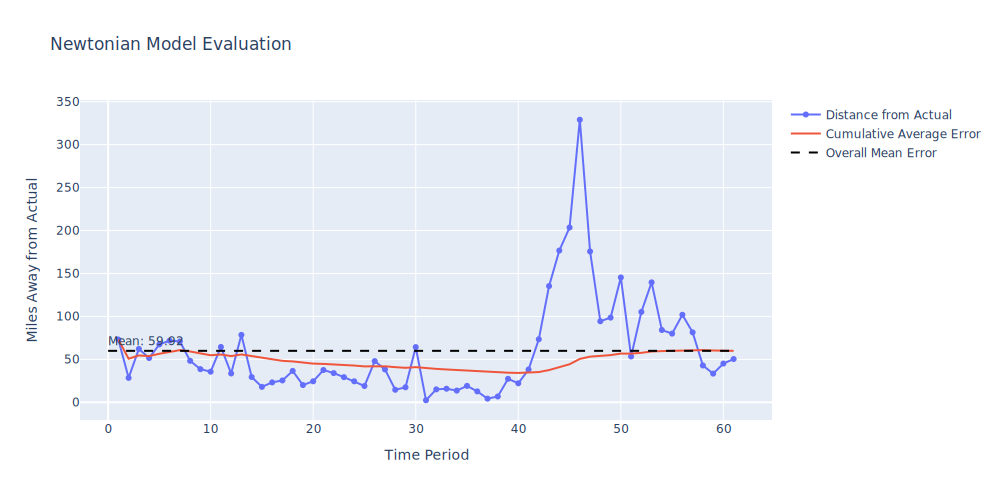

In [24]:
plot_model_evaluations(
    *evaluate_haversine(fiona_df.select("longitude", "latitude").to_numpy(), post_mean.values),
    main_title="Newtonian"
).show(width=1000, renderer="svg")

### Generate 24-hour forecasts with our Newtonian model

In [25]:
f_mean, cppc_vcov = generate_period_forecasts(
    ssm_model=n_ssm, inference_data=newtonian_idata, data=fiona_df, periods=4
)

/opt/miniconda3/envs/pymc_examples_dev/lib/python3.13/site-packages/pymc_extras/statespace/utils/data_tools.py:74: UserWarning:

No time index found on the supplied data. A simple range index will be automatically generated.

Sampling: [forecast_combined]
/opt/miniconda3/envs/pymc_examples_dev/lib/python3.13/site-packages/pymc_extras/statespace/utils/data_tools.py:74: UserWarning:

No time index found on the supplied data. A simple range index will be automatically generated.

Sampling: [forecast_combined]
/opt/miniconda3/envs/pymc_examples_dev/lib/python3.13/site-packages/pymc_extras/statespace/utils/data_tools.py:74: UserWarning:

No time index found on the supplied data. A simple range index will be automatically generated.

Sampling: [forecast_combined]
/opt/miniconda3/envs/pymc_examples_dev/lib/python3.13/site-packages/pymc_extras/statespace/utils/data_tools.py:74: UserWarning:

No time index found on the supplied data. A simple range index will be automatically generated.

Sampli

The 4-period (24-hour) forecasts exhibit a smaller error compared to the one-step ahead forecast. This result is due to the smoothing effect that occurs when we forecast out longer time periods.

In [26]:
fig = plot_hurricane_path(
    data=fiona_df, posterior_mean=f_mean, predicted_covariance=cppc_vcov, uncertainty_index=0
)
fig.show(config={"displayModeBar": False})

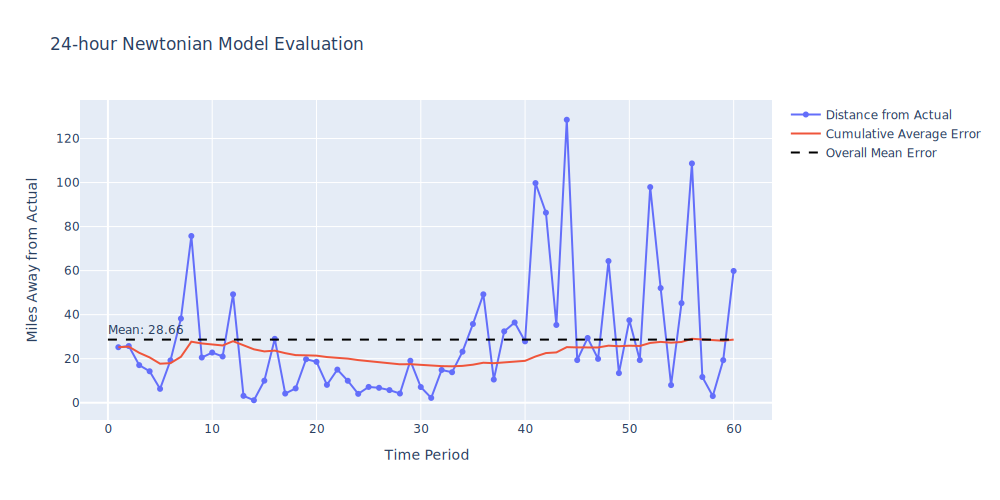

In [27]:
newtonian_errors, newtonian_cum_error, newtonian_mean_error = evaluate_haversine(
    fiona_df.select("longitude", "latitude").to_numpy()[1:], f_mean.values
)
plot_model_evaluations(
    newtonian_errors, newtonian_cum_error, newtonian_mean_error, main_title="24-hour Newtonian"
).show(width=1000, renderer="svg")

## Adding Deterministic Covariates/Exogenous Variables
In our dataset we have variables that aren't a part of the Newtonian system process, but may carry information that we can leverage to better track the path of the hurricane. We have two options when introducing these exogenous variables into our model. We can add them in as time invariant or time-varying variables. In our case, we are going to add exogenous variables as time invariant. Our aim then is to model our observations as:

$$
\hat{y}_{longitude_{t+1}} = longitude_{t} + longitude\_velocity_{t}\Delta t + \frac{longitude\_acceleration_{t}\Delta t^{2}}{2} + \beta_{exogenous_{longitude}} exogenous\_data
$$

$$
\hat{y}_{latitude_{t+1}} = latitude_{t} + latitude\_velocity_{t}\Delta t + \frac{latitude\_acceleration_{t}\Delta t^{2}}{2} + \beta_{exogenous_{latitude}} exogenous\_data
$$ 

The `max_wind` variable measures the maximum sustained surface wind at 10 meter elevations and is a uni-dimensional measure (i.e not measured in terms of longitude and latitude). Therefore, we are going to use the same data to estimate two-parameters $\beta_{wind_{longitude}}$ and $\beta_{wind_{latitude}}$. This is less than ideal but demonstrates how to add exogenous variables to a `StateSpace` model.

The `min_pressure` variable measures the minumum central pressure. The lower the central pressure, typically, the more intense the hurricane. This variable again is only measured in one dimension, so we will handle that the same way we are handling it for `max_wind`.

Finally, we will also include the interaction between the maximum sustained surface wind and the minimum central pressure.

In order to put this in matrix form, we are going to add the newly added $\beta$ parameters to our state vector and we will add the corresponding measured `wind_speed`, `min_pressure`, and `interaction_wind_pressure` data into the design matrix. So our new state vector will be: 

$$
x_{t} = \begin{bmatrix}longitude_{t} \\ latitude_{t} \\ longitude\_velocity_{t} \\ latitude\_velocity_{t} \\ longitude\_acceleration_{t} \\ latitude\_acceleration_{t} \\ \beta_{wind_{longitude}} \\ \beta_{wind_{latitude}} \\ \beta_{pressure_{longitude}} \\ \beta_{pressure_{latitude}} \\ \beta_{wind\_pressure_{longitude}} \\ \beta_{wind\_pressure_{latitude}} \end{bmatrix}
$$

and our design matrix will be: 

$$
Z' = \begin{bmatrix} Z & X_{exogenous\_data} \end{bmatrix}
$$ 

Where $Z$ is our previously defined design matrix and $X_{exogenous}$ is the measured `wind_speed`, `minimum_pressure`, and `interaction_wind_pressure` exogenous data.

We also need to make adjustments to our $A$ state transition matrix and $R$ selection matrix.

$$
T = \begin{bmatrix}1&0&\Delta t&0&\frac{\Delta t^{2}}{2}&0&1&0&1&0&1&0 \\ 0&1&0&\Delta t&0&\frac{\Delta t^{2}}{2}&0&1&0&1&0&1  \\ 0&0&1&0&\Delta t&0&0&0&0&0&0&0 \\ 0&0&0&1&0&\Delta t&0&0&0&0&0&0 \\ 0&0&0&0&1&0&0&0&0&0&0&0 \\ 0&0&0&0&0&1&0&0&0&0&0&0 \\ 0&0&0&0&0&0&1&0&0&0&0&0 \\ 0&0&0&0&0&0&0&1&0&0&0&0 \\ 0&0&0&0&0&0&0&0&1&0&0&0 \\ 0&0&0&0&0&0&0&0&0&1&0&0 \\ 0&0&0&0&0&0&0&0&0&0&1&0 \\ 0&0&0&0&0&0&0&0&0&0&0&1 \end{bmatrix}
$$

The last 2 columns we added indicates what states our exogenous variables affect, and the last 2 rows indicate that the processes of our exogenous parameters are constant.

$$
R = \begin{bmatrix} 1&0&0&0&0&0 \\ 
                      0&1&0&0&0&0 \\
                      0&0&1&0&0&0 \\
                      0&0&0&1&0&0 \\
                      0&0&0&0&1&0 \\ 
                      0&0&0&0&0&1 \\
                      0&0&0&0&0&0 \\
                      0&0&0&0&0&0 \\
                      0&0&0&0&0&0 \\
                      0&0&0&0&0&0 \\
                      0&0&0&0&0&0 \\
                      0&0&0&0&0&0 
       \end{bmatrix}
$$

The additions to the R matrix imply that the exogenous parameters do not exhibit any process innovations.

In [28]:
class ExogenousSSM(PyMCStateSpace):
    def __init__(self, k_exog: int = None, mode: str | None = None):
        k_states = 6 + k_exog  # number of states (x, y, vx, vy, ax, ay)
        k_posdef = 6  # number of shocks (size of the process innovations covariance matrix Q)
        k_endog = 2  # number of observed states (we only observe x and y)
        self.k_exog = k_exog
        mode = mode

        super().__init__(k_endog=k_endog, k_states=k_states, k_posdef=k_posdef, mode=mode)

    def make_symbolic_graph(self):
        # Add exogenous variables to the model
        exogenous_data = self.make_and_register_data("exogenous_data", shape=(None, self.k_exog))
        beta_exog = self.make_and_register_variable("beta_exog", shape=(self.k_exog,))
        n_obs = exogenous_data.shape[0]

        delta_t = 6.0  # The amount of time between observations 6 hours in our case
        # these variables wil be estimated in our model
        x0 = self.make_and_register_variable(
            "x0", shape=(6,)
        )  # initial state vector (x, y, vx, vy, ax, ay)
        P0 = self.make_and_register_variable(
            "P0", shape=(self.k_states, self.k_states)
        )  # initial process covariance matrix
        acceleration_innovations = self.make_and_register_variable(
            "acceleration_innovations", shape=(1,)
        )

        T = np.array(
            [
                [1, 0, delta_t, 0, (delta_t**2) / 2, 0],
                [0, 1, 0, delta_t, 0, (delta_t**2) / 2],
                [0, 0, 1, 0, delta_t, 0],
                [0, 0, 0, 1, 0, delta_t],
                [0, 0, 0, 0, 1, 0],
                [0, 0, 0, 0, 0, 1],
            ]
        )

        self.ssm["transition", :, :] = np.vstack(
            (
                np.hstack((T, np.zeros(shape=(self.k_states - self.k_exog, self.k_exog)))),
                np.eye(self.k_states)[-self.k_exog :],
            )
        )

        R = np.array(
            [
                [1, 0, 0, 0, 0, 0],
                [0, 1, 0, 0, 0, 0],
                [0, 0, 1, 0, 0, 0],
                [0, 0, 0, 1, 0, 0],
                [0, 0, 0, 0, 1, 0],
                [0, 0, 0, 0, 0, 1],
            ]
        )

        self.ssm["selection", :, :] = np.vstack(
            (R, np.zeros(shape=(self.k_exog, self.k_states - self.k_exog)))
        )

        Z = pt.as_tensor([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]])
        exog_reshape = pt.repeat(
            exogenous_data, self.k_endog, axis=0
        )  # We need to reshape the data to fit the proper dimensions. This step duplicates the data
        exog_reshape = pt.set_subtensor(
            exog_reshape[1::2, :], pt.roll(exog_reshape[1::2, :], 1)
        )  # We need to reshape the data to fit the proper dimensions. This step mirrors the data
        exog_reshape = exog_reshape.reshape((n_obs, self.k_endog, self.k_exog))

        self.ssm["design"] = pt.concatenate((pt.tile(Z, (n_obs, 1, 1)), exog_reshape), axis=2)

        self.ssm["initial_state", :] = pt.concatenate((x0, beta_exog), axis=0)
        self.ssm["initial_state_cov", :, :] = P0

        self.ssm["state_cov", :, :] = acceleration_innovations**2 * np.array(
            [
                [(delta_t**4) / 4, 0, (delta_t**3) / 2, 0, (delta_t**2) / 2, 0],
                [0, (delta_t**4) / 4, 0, (delta_t**3) / 2, 0, (delta_t**2) / 2],
                [(delta_t**3) / 2, 0, (delta_t**2), 0, delta_t, 0],
                [0, (delta_t**3) / 2, 0, (delta_t**2), 0, delta_t],
                [(delta_t**2) / 2, 0, delta_t, 0, 1, 0],
                [0, (delta_t**2) / 2, 0, delta_t, 0, 1],
            ]
        )
        self.ssm["obs_cov", :, :] = np.eye(2) * 0.5

    @property
    def data_names(self) -> list[str]:
        """
        Names of data variables expected by the model.

        This does not include the observed data series, which is automatically handled by PyMC. This property only
        needs to be implemented for models that expect exogenous data.
        """
        return ["exogenous_data"]

    @property
    def data_info(self):
        """
        Information about Data variables that need to be declared in the PyMC model block.

        Returns a dictionary of data_name: dictionary of property-name:property description pairs. The return value is
        used by the ``_print_data_requirements`` method, to print a message telling users how to define the necessary
        data for the model. Each dictionary should have the following key-value pairs:
            * key: "shape", value: a tuple of integers
            * key: "dims", value: tuple of strings
        """
        return {"exogenous_data": {"shape": (None, self.k_exog), "dims": (TIME_DIM, "exog_dims")}}

    @property
    def param_names(self):
        return ["x0", "P0", "acceleration_innovations", "beta_exog"]

    @property
    def state_names(self):
        return [
            "x",
            "y",
            "vx",
            "vy",
            "ax",
            "ay",
            "beta_wind_x",
            "beta_wind_y",
            "beta_pressure_x",
            "beta_pressure_y",
            "interaction_wind_pressure_x",
            "interaction_wind_pressure_y",
        ]

    @property
    def shock_names(self):
        return [
            "x_innovations",
            "y_innovations",
            "vx_innovations",
            "vy_innovations",
            "ax_innovations",
            "ay_innovations",
        ]

    @property
    def observed_states(self):
        return ["x", "y"]

    @property
    def param_dims(self):
        # There are special standardized names to use here. You can import them from
        # pymc_extras.statespace.utils.constants

        return {
            "x0": (self.k_states - self.k_exog,),
            "P0": (ALL_STATE_DIM, ALL_STATE_AUX_DIM),
            "acceleration_innovations": (1,),
            "beta_exog": ("exog_dims",),
        }

    @property
    def coords(self):
        # This function puts coords on all those statespace matrices (x0, P0, c, d, T, Z, R, H, Q)
        # and also on the different filter outputs so you don't have to worry about it. You only need to set
        # the coords for the dims unique to your model.
        coords = make_default_coords(self)
        coords.update(
            {
                "exog_dims": [
                    "Wind_Longitude",
                    "Wind_Latitude",
                    "Pressure_Longitude",
                    "Pressure_Latitude",
                    "Interaction_Wind_Pressure_Longitude",
                    "Interaction_Wind_Pressure_Latitude",
                ]
            }
        )
        return coords

    @property
    def param_info(self):
        # This needs to return a dictionary where the keys are the parameter names, and the values are a
        # dictionary. The value dictionary should have the following keys: "shape", "constraints", and "dims".

        info = {
            "x0": {
                "shape": (self.k_states - self.k_exog,),
                "constraints": "None",
            },
            "P0": {
                "shape": (self.k_states, self.k_states),
                "constraints": "Positive Semi-definite",
            },
            "acceleration_innovations": {
                "shape": (1,),
                "constraints": "Positive",
            },
            "beta_exog": {
                "shape": (self.k_exog,),
                "constraints": "None",
            },
        }

        # Lazy way to add the dims without making any typos
        for name in self.param_names:
            info[name]["dims"] = self.param_dims[name]

        return info

Note that because our variables are uni-dimensional we duplicate and mirror the data to apply each variable in two dimensions. The mirroring occurs in the model definition of the design matrix. This is necessary to ensure that the correct data is associated with the proper state during matrix multiplication. Take a look at how the states are defined above. In order to have a univariate variable apply to both the longitude and latitude positions (our observed states) we must duplicate our exogenous data for each observed stated and mirror the data so that when we are multiplying the exogenous data with the longitudinal states the data is non-zero on the longitudinal state but is zero for the latitudinal states and vice versa.

In [29]:
X_exog = (
    fiona_df.with_columns(
        pl.lit(0.0).alias("zeros"),
        ((pl.col("max_wind") - pl.col("max_wind").mean()) / pl.col("max_wind").std()).alias(
            "max_wind"
        ),
        (
            (pl.col("min_pressure") - pl.col("min_pressure").mean()) / pl.col("min_pressure").std()
        ).alias("min_pressure"),
    )
    .with_columns((pl.col("max_wind") * pl.col("min_pressure")).alias("interaction_wind_pressure"))
    .select(
        pl.col("max_wind").cast(pl.Float64).alias("max_wind_x"),
        pl.col("zeros").cast(pl.Float64).alias("max_wind_y"),
        pl.col("min_pressure").cast(pl.Float64).alias("min_pressure_x"),
        pl.col("zeros").cast(pl.Float64).alias("min_pressure_y"),
        pl.col("interaction_wind_pressure").cast(pl.Float64).alias("interaction_wind_pressure_x"),
        pl.col("zeros").cast(pl.Float64).alias("interaction_wind_pressure_y"),
    )
)

In [30]:
exog_ssm = ExogenousSSM(k_exog=X_exog.shape[1], mode="JAX")

                                    Model Requirements                                    
                                                                                          
  Variable                   Shape       Constraints                          Dimensions  
 ──────────────────────────────────────────────────────────────────────────────────────── 
  x0                         (6,)        None                                       (6,)  
  P0                         (12, 12)    Positive Semi-definite   ('state', 'state_aux')  
  acceleration_innovations   (1,)        Positive                                   (1,)  
  beta_exog                  (6,)        None                             ('exog_dims',)  
                                                                                          
  exogenous_data             (None, 6)   pm.Data                   ('time', 'exog_dims')  
                                                                                          
 These parameters should be assigned priors inside a PyMC model block before calling the  
                              build_statespace_graph method.                              

In [31]:
with pm.Model(coords=exog_ssm.coords) as exogenous:
    exogenous_data = pm.Data("exogenous_data", X_exog.to_numpy(), dims=["time", "exog_dims"])
    beta_exog = pm.Normal("beta_exog", 0, 1, dims=["exog_dims"])

    x0 = pm.Deterministic("x0", pt.as_tensor([-49, 16, 0.0, 0.0, 0.0, 0.0]))
    P0 = pt.eye(12) * 1e-3
    P0 = pm.Deterministic("P0", P0, dims=("state", "state_aux"))

    acceleration_innovations = pm.Gamma("acceleration_innovations", 0.1, 5, shape=(1,))

    exog_ssm.build_statespace_graph(
        data=fiona_df.select("longitude", "latitude").to_numpy(),
        save_kalman_filter_outputs_in_idata=True,
    )
    exogenous_idata = pm.sample(
        nuts_sampler="nutpie", nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "jax"}
    )

/opt/miniconda3/envs/pymc_examples_dev/lib/python3.13/site-packages/pymc_extras/statespace/utils/data_tools.py:74: UserWarning:

No time index found on the supplied data. A simple range index will be automatically generated.



Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.62,7
,2000,0,0.64,15
,2000,0,0.60,7
,2000,0,0.61,7


Typically, the surface wind speed and the central pressure of a hurricane carry little information on the path the hurricane will take. The path of a hurricane is, generally, influenced by surrounding atmospheric conditions like pressure gradients. Knowing this, it makes sense to see that many of our beta parameters are close to zero, indicating little to no influence on the hurricanes' path.

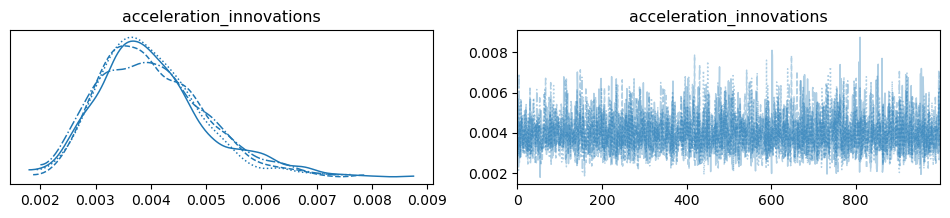

In [32]:
az.plot_trace(exogenous_idata, var_names="acceleration_innovations");

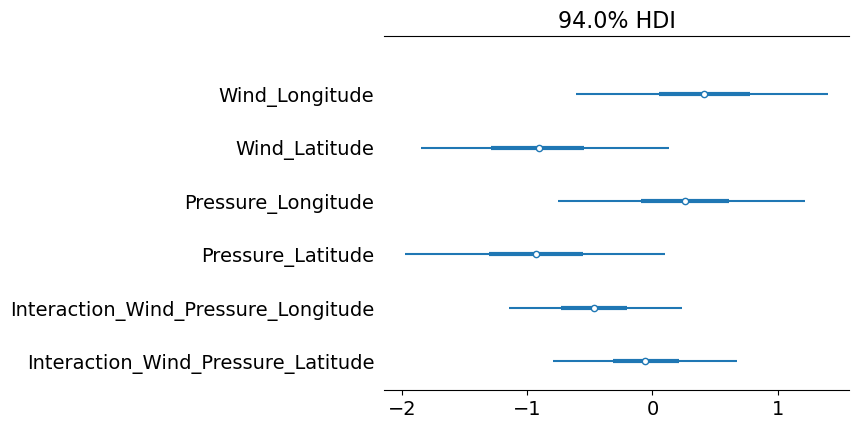

In [33]:
az.plot_forest(
    exogenous_idata, var_names=["beta_exog"], combined=True, labeller=azl.NoVarLabeller()
);

### Make in-sample forecasts with new exogenous model

In [34]:
predicted_covs = exogenous_idata.posterior["predicted_covariance"].mean(("chain", "draw"))
post_mean = exogenous_idata.posterior["predicted_observed_state"].mean(("chain", "draw"))

Our one-period ahead forecasts seem to be slightly worse than our Newtonian model. You will notice that at the end of the forecast we see that our trajectory is erroneously more north rather than north-east. Since the exogenous variables we added to the model don't carry additional information with respect to the hurricane's trajectory, this results are expected.

In [35]:
fig = plot_hurricane_path(
    data=fiona_df,
    posterior_mean=post_mean,
    predicted_covariance=predicted_covs,
    uncertainty_index=0,
)
fig.show(config={"displayModeBar": False})

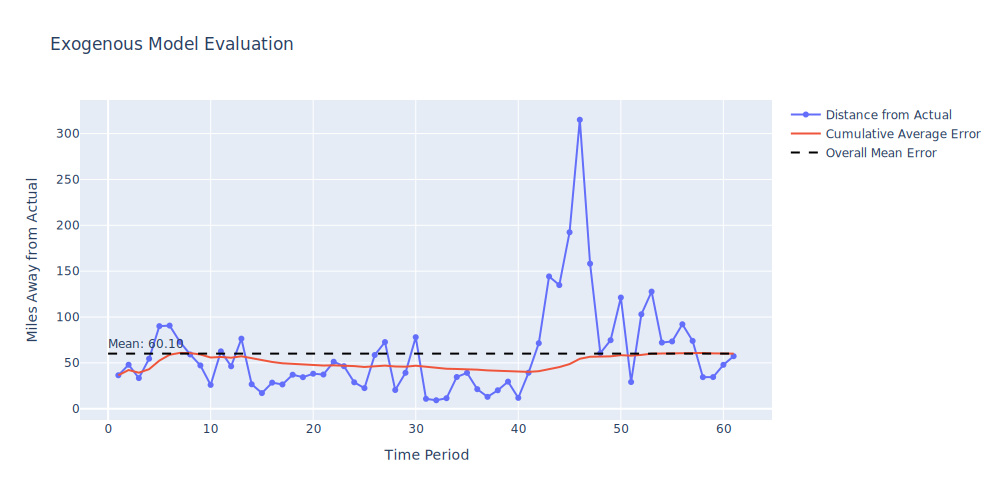

In [36]:
plot_model_evaluations(
    *evaluate_haversine(fiona_df.select("longitude", "latitude").to_numpy(), post_mean.values),
    main_title="Exogenous"
).show(width=1000, renderer="svg")

### Generate 24-hour forecasts with our Exogenous SSM

We need to be careful here because we must ensure that we don't allow our model to peak into the future by supplying it with exogenous data that we would not have seen at the time of generating our forecasts. To ensure good and fair forecasts, we will be carrying forward the last exogenous data points from our prior period.  

In [37]:
# Carry forward last observation
X_exog_scenario = X_exog.gather_every(n=4, offset=4).select(pl.all().repeat_by(4).flatten())

# our last i will equal 60 so we need to pad our exogenous data to len 64
X_exog_padded = pl.concat(
    (
        X_exog_scenario,
        X_exog_scenario.tail(1).select(
            pl.all().repeat_by(4).flatten()
        ),  # duplicate last entry 4 times
    )
)

In [38]:
f_mean, cppc_vcov = generate_period_forecasts(
    ssm_model=exog_ssm,
    inference_data=exogenous_idata,
    data=fiona_df,
    periods=4,
    exogenous_data_name="exogenous_data",
    padded_exogenous_data=X_exog_padded,
)

/opt/miniconda3/envs/pymc_examples_dev/lib/python3.13/site-packages/pymc_extras/statespace/utils/data_tools.py:74: UserWarning:

No time index found on the supplied data. A simple range index will be automatically generated.

Sampling: [forecast_combined]
/opt/miniconda3/envs/pymc_examples_dev/lib/python3.13/site-packages/pymc_extras/statespace/utils/data_tools.py:74: UserWarning:

No time index found on the supplied data. A simple range index will be automatically generated.

Sampling: [forecast_combined]
/opt/miniconda3/envs/pymc_examples_dev/lib/python3.13/site-packages/pymc_extras/statespace/utils/data_tools.py:74: UserWarning:

No time index found on the supplied data. A simple range index will be automatically generated.

Sampling: [forecast_combined]
/opt/miniconda3/envs/pymc_examples_dev/lib/python3.13/site-packages/pymc_extras/statespace/utils/data_tools.py:74: UserWarning:

No time index found on the supplied data. A simple range index will be automatically generated.

Sampli

Similarly, our 24-hour forecasts are also slightly worse off compared to those produced by the simple model.

In [39]:
fig = plot_hurricane_path(
    data=fiona_df, posterior_mean=f_mean, predicted_covariance=cppc_vcov, uncertainty_index=0
)
fig.show(config={"displayModeBar": False})

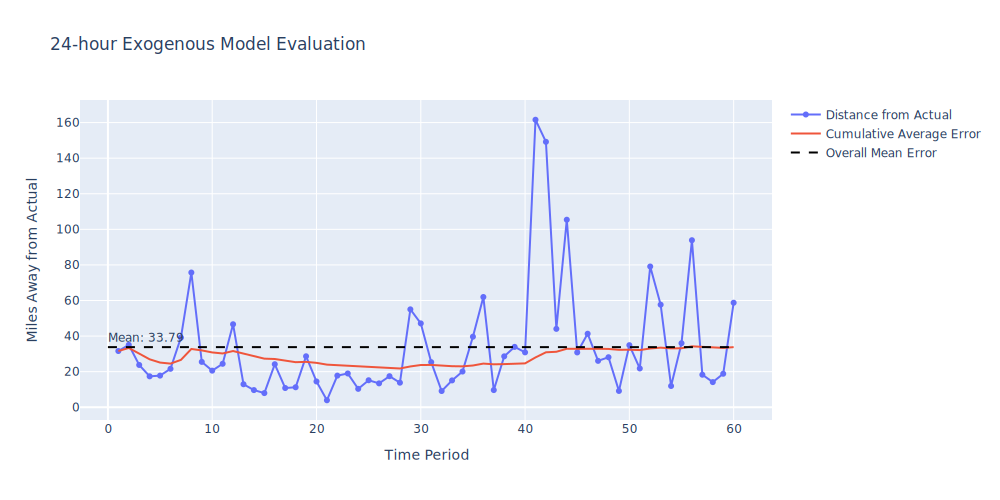

In [40]:
exog_errors, exog_cum_error, exog_mean_error = evaluate_haversine(
    fiona_df.select("longitude", "latitude").to_numpy()[1:], f_mean.values
)
plot_model_evaluations(
    exog_errors, exog_cum_error, exog_mean_error, main_title="24-hour Exogenous"
).show(width=1000, renderer="svg")

## Add B-Splines
In the previous section, we tried adding an interaction term between the maximum sustained surface wind speed and the minumum central pressure. However, our estimated parameters were not too far off from zero. In this section we are going to attempt to model the non-linear complexities of the path, particularly in the mid-section, using cubic B-splines.

We first need to define what variables we are going to model as a smooth function. In our case, we are going to model the longitude values as a smooth function of the latitude values and vice versa. 

To keep things simple, we are going to define a constant number of knots that are equal in both variables (same number of knots for both longitude and latitude) and we are going to place the knots using a quantile function over the variable space. You can see the knots plotted out below for each variable.

In [41]:
num_knots = 15
longitude_knot_list = np.quantile(fiona_df["longitude"], np.linspace(0, 1, num_knots))
latitude_knot_list = np.quantile(fiona_df["latitude"], np.linspace(0, 1, num_knots))

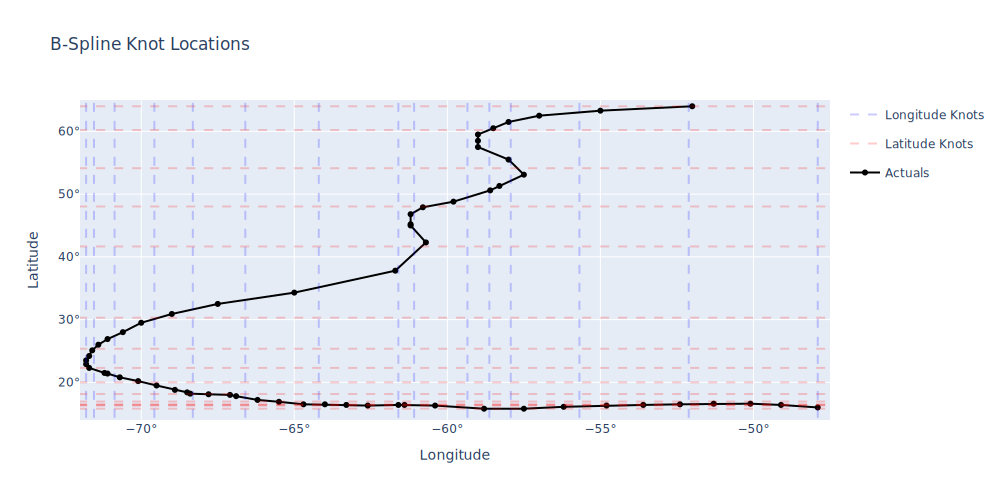

In [42]:
fig = go.Figure()
fig.add_traces(
    [
        go.Scatter(
            x=fiona_df["longitude"],
            y=fiona_df["latitude"],
            name="Actuals",
            mode="lines+markers",
            line=dict(color="black"),
            hovertemplate=[
                f"""<b>Period:</b> {row['discrete_time']}<br><b>Longitude:</b> {row['longitude']:.1f}<br><b>Latitude:</b> {row['latitude']:.1f}<extra></extra>
            """
                for row in fiona_df.iter_rows(named=True)
            ],
        )
    ]
)

for i, knot in enumerate(longitude_knot_list):
    if i == len(longitude_knot_list) - 1:
        showlegend = True
    else:
        showlegend = False
    fig.add_shape(
        type="line",
        x0=knot,
        x1=knot,
        y0=0,
        y1=100,
        line_dash="dash",
        line_color="rgba(0, 0, 255, 0.2)",
        showlegend=showlegend,
        legendgroup="longitude_group",
        name="Longitude Knots",
        legendrank=1,
    )

for i, knot in enumerate(latitude_knot_list):
    if i == len(latitude_knot_list) - 1:
        showlegend = True
    else:
        showlegend = False
    fig.add_shape(
        type="line",
        x0=-75,
        x1=-45,
        y0=knot,
        y1=knot,
        line_dash="dash",
        line_color="rgba(255, 0, 0, 0.2)",
        showlegend=showlegend,
        legendgroup="latitude_group",
        name="Latitude Knots",
        legendrank=2,
    )
fig.update_layout(
    xaxis=dict(title="Longitude", ticksuffix="&#176;", range=(-72, -47.5)),
    yaxis=dict(title="Latitude", ticksuffix="&#176;", range=(14, 65)),
    title=dict(text="B-Spline Knot Locations"),
)
fig.show(width=1000, renderer="svg")

Next, we need to create the basis functions over the defined variable space knot locations for each variable.

In [43]:
B_longitude = dmatrix(
    "bs(longitude, knots=longitude_knots, degree=3, include_intercept=True) - 1",
    {"longitude": fiona_df["longitude"], "longitude_knots": longitude_knot_list[1:-1]},
)

B_latitude = dmatrix(
    "bs(latitude, knots=latitude_knots, degree=3, include_intercept=True) - 1",
    {"latitude": fiona_df["latitude"], "latitude_knots": latitude_knot_list[1:-1]},
)

In [44]:
exog_data = np.column_stack((np.asarray(B_longitude, order="F"), np.asarray(B_latitude, order="F")))

Our new models' structure is going to be similar to our last model that had exogenous variables. However, in this case our data are going to be the basis functions we created earlier. These will be inserted into our design matrix ($Z$) and the beta parameters corresponding to each spline will be added to our  state vector ($x_{t}$). Again, these parameters will be constant (non-time varying). We will also have to adjust our transition matrix ($T$) and selection matrix ($R$) similar to how we did previously. We will now have:

$$
\hat{y}_{longitude_{t+1}} = longitude_{t} + longitude\_velocity_{t}\Delta t + \frac{longitude\_acceleration_{t}\Delta t^{2}}{2} + \beta_{spline\_params_{longitude}} longitude\_spline\_basis\_functions
$$

$$
\hat{y}_{latitude_{t+1}} = latitude_{t} + latitude\_velocity_{t}\Delta t + \frac{latitude\_acceleration_{t}\Delta t^{2}}{2} + \beta_{spline\_params_{latitude}} latitude\_spline\_basis\_functions
$$ 

our design matrix will be: 

$$
Z' = \begin{bmatrix} Z & X_{basis\_functions} \end{bmatrix}
$$ 

Where $Z$ is our previously defined design matrix and $X_{exogenous}$ are the basis functions we defined earlier.

Our transition matrix will be 

$$
T' = \begin{bmatrix} T & F \\ 0 & I_{n\_spline\_params} \end{bmatrix}
$$

Where $T$ is the transition matrix defined for the Newtonian kinematics (the top-left 6x6 block in our previous model)
and 

$$
F =  \begin{bmatrix} 1&0&1&0&1&0&1&0&1&0&1&0&1&0&1&0&1&0&1&0&1&0&1&0&1&0&1&0&1&0&1&0&1&0 \\ 0&1&0&1&0&1&0&1&0&1&0&1&0&1&0&1&0&1&0&1&0&1&0&1&0&1&0&1&0&1&0&1&0&1 \\ 0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0 \\ 0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0 \\ 0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0 \\ 0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0 \end{bmatrix}
$$ 

and the 0 in the matrix above is a matrix of 0s of shape (number of spline parameters by number of spline parameters)

Finally, we have 

$$
R' = \begin{bmatrix} R \\ 0 \end{bmatrix}
$$

Where R is the selection matrix over our endogenous states (identity matrix of shape (number of states))
and again the 0 in the matrix is a matrix of 0s with shape (number of spline parameters by number of states)

In [45]:
class SplineSSM(PyMCStateSpace):
    def __init__(self, k_exog: int = None, mode: str | None = None):
        k_states = 6 + k_exog  # number of states (x, y, vx, vy, ax, ay)
        k_posdef = 6  # number of shocks (size of the process innovations covariance matrix Q)
        k_endog = 2  # number of observed states (we only observe x and y)
        self.k_exog = k_exog
        mode = mode

        super().__init__(k_endog=k_endog, k_states=k_states, k_posdef=k_posdef, mode=mode)

    def make_symbolic_graph(self):
        # Add exogenous variables to the model
        exogenous_data = self.make_and_register_data("exogenous_data", shape=(None, self.k_exog))
        beta_exog = self.make_and_register_variable("beta_exog", shape=(self.k_exog,))
        n_obs = exogenous_data.shape[0]

        delta_t = 6.0  # The amount of time between observations 6 hours in our case
        # these variables wil be estimated in our model
        x0 = self.make_and_register_variable(
            "x0", shape=(6,)
        )  # initial state vector (x, y, vx, vy, ax, ay)
        P0 = self.make_and_register_variable(
            "P0", shape=(self.k_states, self.k_states)
        )  # initial process covariance matrix
        acceleration_innovations = self.make_and_register_variable(
            "acceleration_innovations", shape=(1,)
        )

        T = np.array(
            [
                [1, 0, delta_t, 0, (delta_t**2) / 2, 0],
                [0, 1, 0, delta_t, 0, (delta_t**2) / 2],
                [0, 0, 1, 0, delta_t, 0],
                [0, 0, 0, 1, 0, delta_t],
                [0, 0, 0, 0, 1, 0],
                [0, 0, 0, 0, 0, 1],
            ]
        )

        self.ssm["transition", :, :] = np.vstack(
            (
                np.hstack((T, np.zeros(shape=(self.k_states - self.k_exog, self.k_exog)))),
                np.eye(self.k_states)[-self.k_exog :],
            )
        )

        R = np.array(
            [
                [1, 0, 0, 0, 0, 0],
                [0, 1, 0, 0, 0, 0],
                [0, 0, 1, 0, 0, 0],
                [0, 0, 0, 1, 0, 0],
                [0, 0, 0, 0, 1, 0],
                [0, 0, 0, 0, 0, 1],
            ]
        )

        self.ssm["selection", :, :] = np.vstack(
            (R, np.zeros(shape=(self.k_exog, self.k_states - self.k_exog)))
        )

        Z = pt.as_tensor([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]])
        exog_reshape = pt.horizontal_stack(
            pt.concatenate(
                (
                    exogenous_data[:, : int(self.k_exog / 2)],
                    pt.zeros((n_obs, int(self.k_exog / 2))),
                ),
                axis=1,
            ),
            pt.concatenate(
                (
                    pt.zeros((n_obs, int(self.k_exog / 2))),
                    exogenous_data[:, int(self.k_exog / 2) :],
                ),
                axis=1,
            ),
        ).reshape((n_obs, self.k_endog, self.k_exog))

        self.ssm["design"] = pt.concatenate((pt.tile(Z, (n_obs, 1, 1)), exog_reshape), axis=2)

        self.ssm["initial_state", :] = pt.concatenate((x0, beta_exog), axis=0)
        self.ssm["initial_state_cov", :, :] = P0

        self.ssm["state_cov", :, :] = acceleration_innovations**2 * np.array(
            [
                [(delta_t**4) / 4, 0, (delta_t**3) / 2, 0, (delta_t**2) / 2, 0],
                [0, (delta_t**4) / 4, 0, (delta_t**3) / 2, 0, (delta_t**2) / 2],
                [(delta_t**3) / 2, 0, (delta_t**2), 0, delta_t, 0],
                [0, (delta_t**3) / 2, 0, (delta_t**2), 0, delta_t],
                [(delta_t**2) / 2, 0, delta_t, 0, 1, 0],
                [0, (delta_t**2) / 2, 0, delta_t, 0, 1],
            ]
        )
        self.ssm["obs_cov", :, :] = np.eye(2) * 0.5

    @property
    def data_names(self) -> list[str]:
        """
        Names of data variables expected by the model.

        This does not include the observed data series, which is automatically handled by PyMC. This property only
        needs to be implemented for models that expect exogenous data.
        """
        return ["exogenous_data"]

    @property
    def data_info(self):
        """
        Information about Data variables that need to be declared in the PyMC model block.

        Returns a dictionary of data_name: dictionary of property-name:property description pairs. The return value is
        used by the ``_print_data_requirements`` method, to print a message telling users how to define the necessary
        data for the model. Each dictionary should have the following key-value pairs:
            * key: "shape", value: a tuple of integers
            * key: "dims", value: tuple of strings
        """
        return {"exogenous_data": {"shape": (None, self.k_exog), "dims": (TIME_DIM, "exog_dims")}}

    @property
    def param_names(self):
        return ["x0", "P0", "acceleration_innovations", "beta_exog"]

    @property
    def state_names(self):
        return (
            [
                "x",
                "y",
                "vx",
                "vy",
                "ax",
                "ay",
            ]
            + [f"longitude_spline_{i + 1}" for i in range(B_longitude.shape[1])]
            + [f"latitude_spline_{i + 1}" for i in range(B_latitude.shape[1])]
        )

    @property
    def shock_names(self):
        return [
            "x_innovations",
            "y_innovations",
            "vx_innovations",
            "vy_innovations",
            "ax_innovations",
            "ay_innovations",
        ]

    @property
    def observed_states(self):
        return ["x", "y"]

    @property
    def param_dims(self):
        # There are special standardized names to use here. You can import them from
        # pymc_extras.statespace.utils.constants

        return {
            "x0": (self.k_states - self.k_exog,),
            "P0": (ALL_STATE_DIM, ALL_STATE_AUX_DIM),
            "acceleration_innovations": (1,),
            "beta_exog": ("exog_dims",),
        }

    @property
    def coords(self):
        # This function puts coords on all those statespace matrices (x0, P0, c, d, T, Z, R, H, Q)
        # and also on the different filter outputs so you don't have to worry about it. You only need to set
        # the coords for the dims unique to your model.
        coords = make_default_coords(self)
        coords.update(
            {
                "exog_dims": [f"longitude_spline_{i + 1}" for i in range(B_longitude.shape[1])]
                + [f"latitude_spline_{i + 1}" for i in range(B_latitude.shape[1])]
            }
        )
        return coords

    @property
    def param_info(self):
        # This needs to return a dictionary where the keys are the parameter names, and the values are a
        # dictionary. The value dictionary should have the following keys: "shape", "constraints", and "dims".

        info = {
            "x0": {
                "shape": (self.k_states - self.k_exog,),
                "constraints": "None",
            },
            "P0": {
                "shape": (self.k_states, self.k_states),
                "constraints": "Positive Semi-definite",
            },
            "acceleration_innovations": {
                "shape": (1,),
                "constraints": "Positive",
            },
            "beta_exog": {
                "shape": (self.k_exog,),
                "constraints": "None",
            },
        }

        # Lazy way to add the dims without making any typos
        for name in self.param_names:
            info[name]["dims"] = self.param_dims[name]

        return info

In [46]:
spline_ssm = SplineSSM(k_exog=exog_data.shape[1], mode="JAX")

                                    Model Requirements                                     
                                                                                           
  Variable                   Shape        Constraints                          Dimensions  
 ───────────────────────────────────────────────────────────────────────────────────────── 
  x0                         (6,)         None                                       (6,)  
  P0                         (40, 40)     Positive Semi-definite   ('state', 'state_aux')  
  acceleration_innovations   (1,)         Positive                                   (1,)  
  beta_exog                  (34,)        None                             ('exog_dims',)  
                                                                                           
  exogenous_data             (None, 34)   pm.Data                   ('time', 'exog_dims')  
                                                                                           
  These parameters should be assigned priors inside a PyMC model block before calling the  
                              build_statespace_graph method.                               

In [47]:
with pm.Model(coords=spline_ssm.coords) as spline_model:
    exogenous_data = pm.Data("exogenous_data", exog_data, dims=["time", "exog_dims"])
    beta_exog = pm.Normal("beta_exog", 0, 2, dims=["exog_dims"])

    x0 = pm.Deterministic("x0", pt.as_tensor([-49, 16, 0.0, 0.0, 0.0, 0.0]))
    P0 = pt.eye(40) * 1e-3
    P0 = pm.Deterministic("P0", P0, dims=("state", "state_aux"))

    acceleration_innovations = pm.Gamma("acceleration_innovations", 0.1, 5, shape=(1,))

    spline_ssm.build_statespace_graph(
        data=fiona_df.select("longitude", "latitude").to_numpy(),
        save_kalman_filter_outputs_in_idata=True,
    )
    spline_idata = pm.sample(
        nuts_sampler="nutpie", nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "jax"}
    )

/opt/miniconda3/envs/pymc_examples_dev/lib/python3.13/site-packages/pymc_extras/statespace/utils/data_tools.py:74: UserWarning:

No time index found on the supplied data. A simple range index will be automatically generated.



Progress,Draws,Divergences,Step Size,Gradients/Draw
,448,0,0.51,7
,411,0,0.61,7
,438,0,0.54,7
,436,0,0.45,7


Most of our spline parameters are around zero, with a handful of exceptions. Let's take a look at how these effect our forecasts.

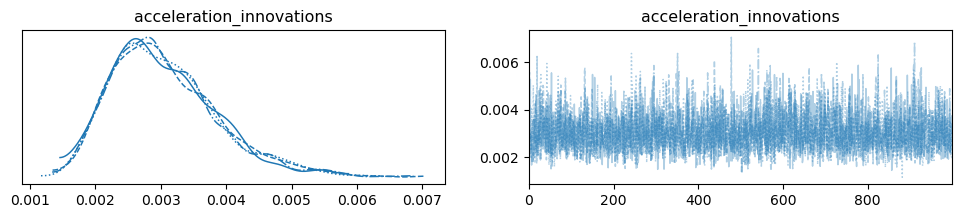

In [48]:
az.plot_trace(spline_idata, var_names="acceleration_innovations");

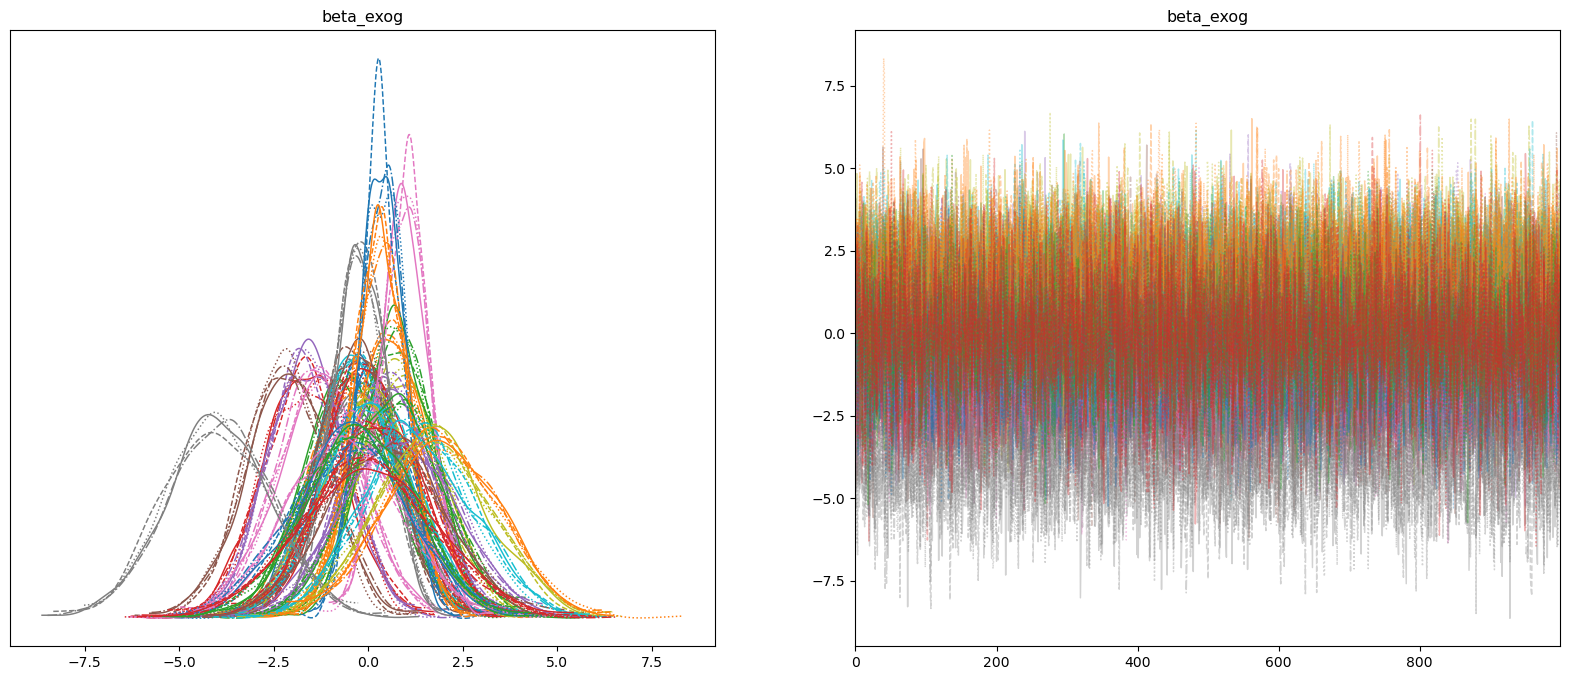

In [49]:
az.plot_trace(spline_idata, var_names=["beta_exog"], compact=True, figsize=(20, 8));

### Make in-sample forecasts with new spline model

Our one-period ahead forecasts, look better than the ones we generated from the Exogenous covariates model, but worse than the original model that purely follows Newtonian kinematics.

In [50]:
predicted_covs = spline_idata.posterior["predicted_covariance"].mean(("chain", "draw"))
post_mean = spline_idata.posterior["predicted_observed_state"].mean(("chain", "draw"))

In [51]:
fig = plot_hurricane_path(
    data=fiona_df,
    posterior_mean=post_mean,
    predicted_covariance=predicted_covs,
    uncertainty_index=0,
)
fig.show(config={"displayModeBar": False})

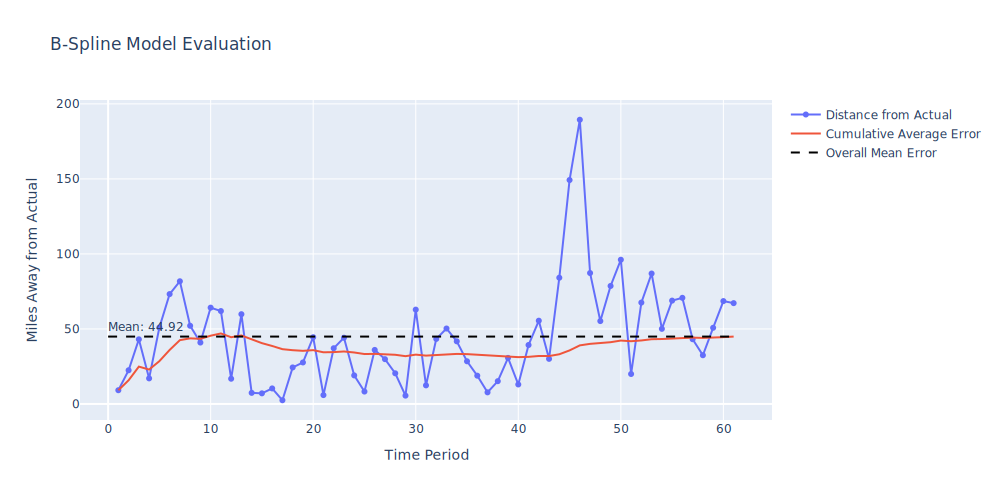

In [52]:
plot_model_evaluations(
    *evaluate_haversine(fiona_df.select("longitude", "latitude").to_numpy(), post_mean.values),
    main_title="B-Spline"
).show(width=1000, renderer="svg")

Our 24-hour (4-period) forecasts, look pretty good. So far, this follows the true trajectory during the mid-section the best. 

In [53]:
# our last i will equal 60 so we need to pad our exogenous data to len 64
exog_data_padded = np.concatenate(
    (exog_data, np.tile(exog_data[60], (3, 1))), axis=0  # duplicate last entry 3 times
)

In [54]:
f_mean, cppc_vcov = generate_period_forecasts(
    ssm_model=spline_ssm,
    inference_data=spline_idata,
    data=fiona_df,
    periods=4,
    exogenous_data_name="exogenous_data",
    padded_exogenous_data=exog_data_padded,
)

/opt/miniconda3/envs/pymc_examples_dev/lib/python3.13/site-packages/pymc_extras/statespace/utils/data_tools.py:74: UserWarning:

No time index found on the supplied data. A simple range index will be automatically generated.

Sampling: [forecast_combined]
/opt/miniconda3/envs/pymc_examples_dev/lib/python3.13/site-packages/pymc_extras/statespace/utils/data_tools.py:74: UserWarning:

No time index found on the supplied data. A simple range index will be automatically generated.

Sampling: [forecast_combined]
/opt/miniconda3/envs/pymc_examples_dev/lib/python3.13/site-packages/pymc_extras/statespace/utils/data_tools.py:74: UserWarning:

No time index found on the supplied data. A simple range index will be automatically generated.

Sampling: [forecast_combined]
/opt/miniconda3/envs/pymc_examples_dev/lib/python3.13/site-packages/pymc_extras/statespace/utils/data_tools.py:74: UserWarning:

No time index found on the supplied data. A simple range index will be automatically generated.

Sampli

In [55]:
fig = plot_hurricane_path(
    data=fiona_df, posterior_mean=f_mean, predicted_covariance=cppc_vcov, uncertainty_index=0
)
fig.show(config={"displayModeBar": False})

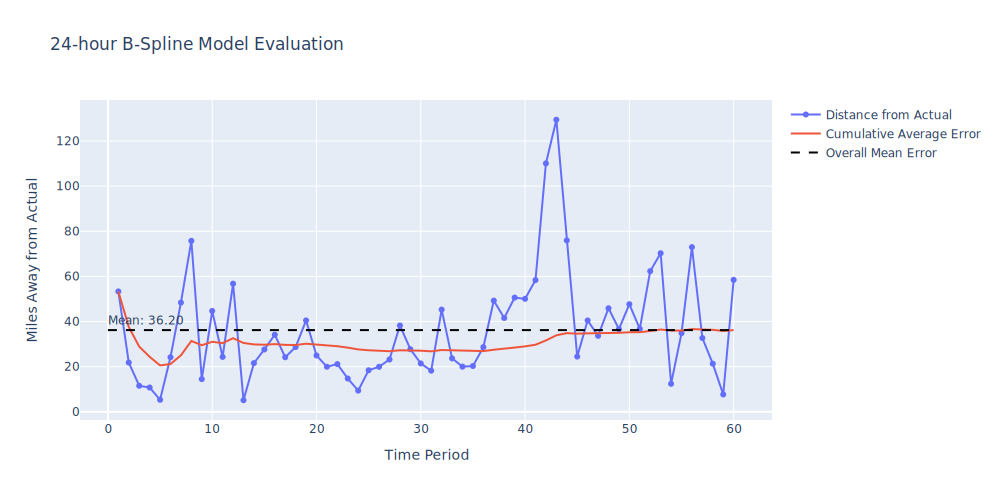

In [56]:
spline_errors, spline_cum_error, spline_mean_error = evaluate_haversine(
    fiona_df.select("longitude", "latitude").to_numpy()[1:], f_mean.values
)
plot_model_evaluations(
    spline_errors, spline_cum_error, spline_mean_error, main_title="24-hour B-Spline"
).show(width=1000, renderer="svg")

## Closing Remarks
In this case study we looked at how we can track a hurricane in two-dimensional space using a state space representation of Newtonian kinematics. We proceeded to expand on the pure Newtonian model and added exogenous variables that may hold information pertintent to the Hurricane's track. We then expanded our model by modeling our variables as smooth functions using cubic B-splines. 

Throughout, the case study we have been evaluating our 24-hour forecasts and our overall mean error is smallest with our first Newtonian model. Below you will find the errors from all three models plotting against one another. It seems that (as expected) the exogenous information we included in the exogenous model was not informative with respect to the hurricances' trajectory. However, it is worth noting that in the period (around 40 through 56) where the hurricane manuevers we obtain less spikes in error in that section with our cubic B-spline model. This implies that the model could benefit from some non-linear specification to handle the angular acceleration. Hopefully, someday the `StateSpace` module in `pymc-extras` may support non-linear state space specifications with either the Extended Kalman Filter or with the Unscented Kalman Filter. Until then you can learn more about how to build your own custom state space models with the `StateSpace` module on the `pymc-extras` official GitHub repository.

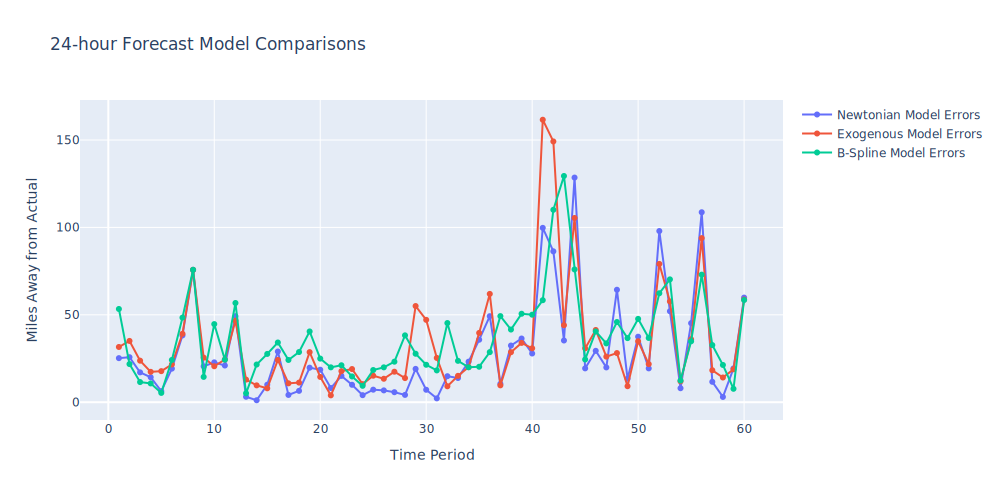

In [57]:
fig = go.Figure()
fig.add_traces(
    [
        go.Scatter(
            x=np.arange(len(newtonian_errors)) + 1,
            y=newtonian_errors,
            mode="markers+lines",
            name="Newtonian Model Errors",
            hovertemplate="<b>Period</b>: %{x}<br><b>Miles Away</b>: %{y}",
        ),
        go.Scatter(
            x=np.arange(len(exog_errors)) + 1,
            y=exog_errors,
            mode="markers+lines",
            name="Exogenous Model Errors",
            hovertemplate="<b>Period</b>: %{x}<br><b>Miles Away</b>: %{y}",
        ),
        go.Scatter(
            x=np.arange(len(spline_errors)) + 1,
            y=spline_errors,
            mode="markers+lines",
            name="B-Spline Model Errors",
            hovertemplate="<b>Period</b>: %{x}<br><b>Miles Away</b>: %{y}",
        ),
    ]
)
fig.update_layout(
    title=f"24-hour Forecast Model Comparisons",
    xaxis=dict(title="Time Period"),
    yaxis=dict(title="Miles Away from Actual"),
    width=1000,
)
fig.show(renderer="svg")

## Authors
* Authored by Jonathan Dekermanjian in June, 2025 

## Acknowledgements
* Chris Fonnesbeck who reviewed and provided valueable feedback that improved the text
* Jesse Grabowski reviewed and provided valueable feedback that improved the text and content, and suggested additional content that improve the overall quality of the work.

## References 

:::{bibliography}
:filter: docname in docnames 

becker2023kalman
:::

## Watermark

In [58]:
%load_ext watermark
%watermark -n -u -v -iv -w -p xarray

Last updated: Sun Jun 15 2025

Python implementation: CPython
Python version       : 3.13.2
IPython version      : 9.0.2

xarray: 2025.3.1

arviz      : 0.21.0
patsy      : 1.0.1
pytensor   : 2.28.3
plotly     : 6.1.2
pymc       : 5.21.1
numpy      : 2.1.3
re         : 2.2.1
xarray     : 2025.3.1
pymc_extras: 0.3.0
polars     : 1.26.0

Watermark: 2.5.0

